In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10540363685800786623, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5102245522228523147
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 723324180116972992
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14053862089115146335
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
!git clone https://github.com/MyGreenSlime/Deeplearning_finalproject

fatal: destination path 'Deeplearning_finalproject' already exists and is not an empty directory.


In [0]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, array_to_img,ImageDataGenerator,img_to_array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import time

In [0]:
BasePath = "./Deeplearning_finalproject/images/"
All_Img = os.listdir(BasePath)
try:
  os.mkdir('images')
except:
  print("folder is existing")

folder is existing


In [0]:
imgs = []
dim = (64,64)
for ind,picname in enumerate(All_Img):
    try:
      img = load_img(BasePath+picname)
      img = img_to_array(img)
      #------------------------------------------------------------------
      img_resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
      imgs.append(img_resized)
      #------------------------------------------------------------------
    except:
      print("error", picname)
      continue   
      

In [0]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(128, (5,5),padding='same',input_shape=(64, 64, 3)))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (5,5),padding='same'))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(512, (5,5),padding='same'))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=(64,64,3))
    validity = model(img)
    
    return Model(img, validity)


def build_generator(latent_dim, img_shape):

    model = Sequential()
    model.add(Dense(2048, activation = 'tanh', input_dim = latent_dim))
    # model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(256*8*8, activation = 'tanh', input_dim = latent_dim))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(alpha = 0.2))
    model.add(Reshape((8,8,256)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(128,(5,5), activation = 'tanh', padding = 'same'))
    # model.add(LeakyReLU(alpha = 0.2))

    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2D(64,(5,5),  activation = 'tanh',padding = 'same'))
    # model.add(LeakyReLU(alpha = 0.2))

    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(3,(5,5),padding = 'same', activation = 'tanh'))
    # model.add(Dense(32*32*128, input_dim=latent_dim))
    # model.add(LeakyReLU())
    # model.add(BatchNormalization())
    # model.add(Reshape((32,32,128)))
    # model.add(Conv2DTranspose(256, 3, strides = (2,2),  padding='same'))
    # model.add(LeakyReLU())
    # model.add(BatchNormalization())
    # model.add(Conv2D(256, 3, padding='same'))
    # model.add(LeakyReLU())
    # model.add(BatchNormalization())
    # model.add(Conv2D(128, 3, padding='same'))
    # model.add(LeakyReLU())
    # model.add(BatchNormalization())
    # model.add(Conv2D(3, 3, padding='same',activation='tanh'))
    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)
    
    return Model(noise, img)

def train(generator,discriminator, combined,X_train, latent_dim,start_epoch,epochs,batch_size=128, sample_interval=50):

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    # X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(start_epoch,epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        if(epoch % 100 == 0):
          print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(generator,epoch, latent_dim)
def sample_images(generator,epoch, latent_dim):
    r, c = 2, 2
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(r * c):
          img = gen_imgs[i].squeeze()
          sub = fig.add_subplot(2, r * c, i+1)
          sub.axis('off')        
          sub.imshow(img)
    # fig, axs = plt.subplots(r, c, figsize = (5,5))
    # cnt = 0
    # for i in range(r):
    #     for j in range(c):
          
    #         axs[i,j].imshow(gen_imgs[cnt])
    #         axs[i,j].axis('off')
    #         cnt += 1
    plt.show()
    fig.savefig("./images/epoch_%d.png" % epoch)
    



In [0]:
len(imgs)
imgs = np.array(imgs)

In [0]:
latent_dim = 100
learning_rate = 0.0002
optimizer = Adam(lr=learning_rate, beta_1 = 0.5)

discriminator = build_discriminator(imgs.shape[1:])
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

generator = build_generator(latent_dim, imgs.shape[1:])

z = Input(shape=(latent_dim,))
img = generator(z)

discriminator.trainable = False

validity = discriminator(img)

combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       9728      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 512)       3

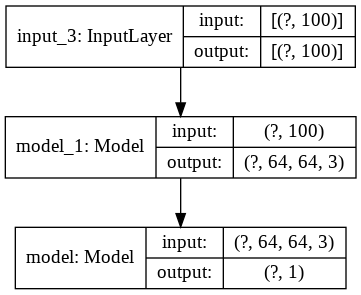

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(combined, show_shapes=True, show_layer_names=True)

0 [D loss: 1.574763, acc.: 0.00%] [G loss: 0.690814]


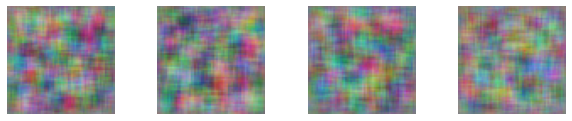

100 [D loss: 0.327179, acc.: 91.02%] [G loss: 10.917935]
200 [D loss: 0.095472, acc.: 98.05%] [G loss: 6.285990]
300 [D loss: 0.115120, acc.: 95.70%] [G loss: 4.972375]
400 [D loss: 1.136888, acc.: 56.25%] [G loss: 5.797761]
500 [D loss: 0.047203, acc.: 99.22%] [G loss: 3.479450]


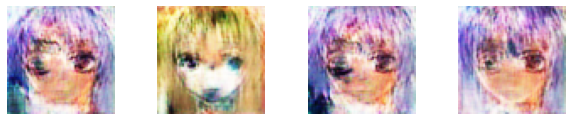

600 [D loss: 0.156680, acc.: 95.70%] [G loss: 3.261597]
700 [D loss: 0.089311, acc.: 97.27%] [G loss: 14.471776]
800 [D loss: 0.333579, acc.: 89.06%] [G loss: 3.314677]
900 [D loss: 0.469523, acc.: 74.61%] [G loss: 2.957650]
1000 [D loss: 0.023392, acc.: 100.00%] [G loss: 4.729346]


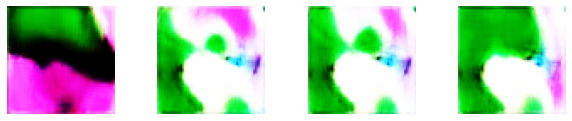

1100 [D loss: 0.145185, acc.: 98.44%] [G loss: 3.461170]
1200 [D loss: 0.516674, acc.: 81.64%] [G loss: 2.099877]
1300 [D loss: 0.481531, acc.: 81.25%] [G loss: 1.745527]
1400 [D loss: 0.332637, acc.: 89.45%] [G loss: 2.555847]
1500 [D loss: 0.370251, acc.: 85.55%] [G loss: 2.902650]


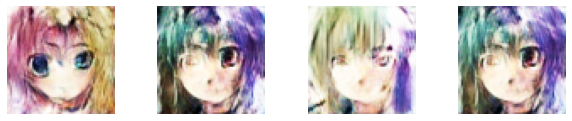

1600 [D loss: 0.249813, acc.: 91.02%] [G loss: 2.877426]
1700 [D loss: 0.280118, acc.: 91.41%] [G loss: 2.768789]
1800 [D loss: 0.254288, acc.: 88.67%] [G loss: 4.105896]
1900 [D loss: 0.286588, acc.: 89.45%] [G loss: 2.646340]
2000 [D loss: 0.222620, acc.: 94.53%] [G loss: 3.258006]


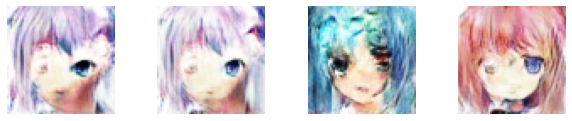

2100 [D loss: 0.225142, acc.: 92.58%] [G loss: 3.067547]
2200 [D loss: 0.309403, acc.: 89.06%] [G loss: 3.199991]
2300 [D loss: 0.681543, acc.: 66.41%] [G loss: 2.935139]
2400 [D loss: 0.259078, acc.: 89.84%] [G loss: 2.920843]
2500 [D loss: 0.158709, acc.: 95.70%] [G loss: 3.684794]


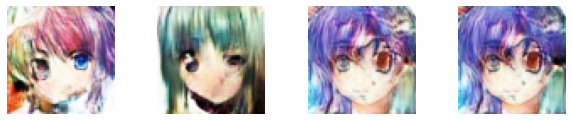

2600 [D loss: 0.211543, acc.: 92.58%] [G loss: 3.106627]
2700 [D loss: 0.169500, acc.: 95.70%] [G loss: 5.328420]
2800 [D loss: 1.053410, acc.: 54.69%] [G loss: 2.405509]
2900 [D loss: 0.452956, acc.: 75.78%] [G loss: 4.733300]
3000 [D loss: 0.180324, acc.: 93.36%] [G loss: 3.464044]


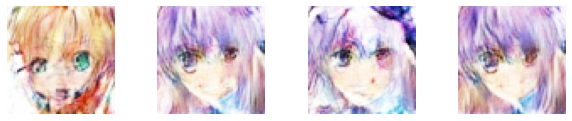

3100 [D loss: 0.063026, acc.: 99.22%] [G loss: 4.213177]
3200 [D loss: 0.131404, acc.: 95.31%] [G loss: 4.446085]
3300 [D loss: 0.204025, acc.: 91.41%] [G loss: 4.762359]
3400 [D loss: 0.249884, acc.: 94.14%] [G loss: 3.656765]
3500 [D loss: 0.200654, acc.: 92.19%] [G loss: 4.318223]


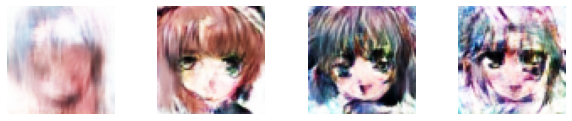

3600 [D loss: 0.115312, acc.: 97.66%] [G loss: 4.979322]
3700 [D loss: 0.143137, acc.: 95.31%] [G loss: 4.509621]
3800 [D loss: 0.077075, acc.: 97.66%] [G loss: 4.127528]
3900 [D loss: 0.077749, acc.: 98.44%] [G loss: 3.923525]
4000 [D loss: 0.102403, acc.: 98.05%] [G loss: 4.573920]


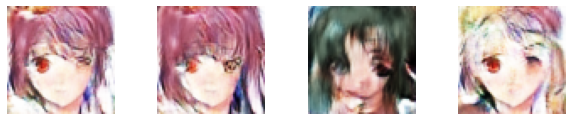

4100 [D loss: 0.085044, acc.: 96.88%] [G loss: 4.731563]
4200 [D loss: 0.115571, acc.: 97.27%] [G loss: 4.716572]
4300 [D loss: 0.423662, acc.: 80.86%] [G loss: 6.219518]
4400 [D loss: 0.076991, acc.: 97.66%] [G loss: 3.614617]
4500 [D loss: 0.265207, acc.: 87.89%] [G loss: 5.926009]


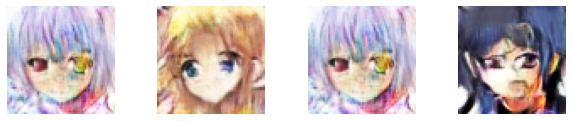

4600 [D loss: 0.108714, acc.: 96.88%] [G loss: 5.046058]
4700 [D loss: 0.179933, acc.: 96.09%] [G loss: 4.689229]
4800 [D loss: 0.108130, acc.: 96.88%] [G loss: 4.213424]
4900 [D loss: 0.222904, acc.: 89.06%] [G loss: 9.307638]
5000 [D loss: 0.219496, acc.: 93.75%] [G loss: 6.973364]


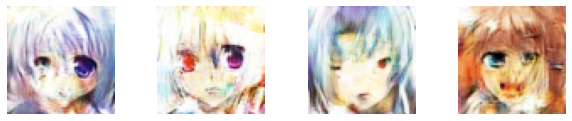

5100 [D loss: 0.083549, acc.: 98.05%] [G loss: 5.328302]
5200 [D loss: 0.151638, acc.: 96.09%] [G loss: 4.934175]
5300 [D loss: 0.106732, acc.: 96.48%] [G loss: 3.846557]
5400 [D loss: 0.123095, acc.: 95.70%] [G loss: 6.848001]
5500 [D loss: 0.043912, acc.: 99.22%] [G loss: 5.106506]


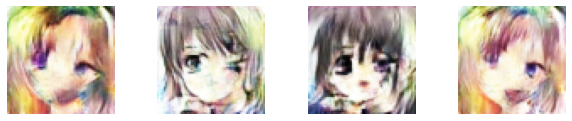

5600 [D loss: 1.032546, acc.: 48.05%] [G loss: 9.005444]
5700 [D loss: 0.141031, acc.: 94.53%] [G loss: 3.415958]
5800 [D loss: 0.126826, acc.: 96.09%] [G loss: 5.051558]
5900 [D loss: 0.077303, acc.: 96.88%] [G loss: 5.222466]
6000 [D loss: 0.077871, acc.: 97.27%] [G loss: 5.379553]


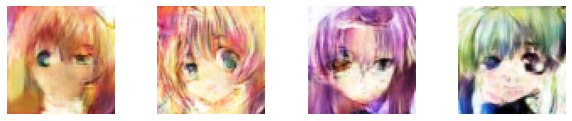

6100 [D loss: 0.143667, acc.: 96.09%] [G loss: 3.763290]
6200 [D loss: 0.132571, acc.: 95.70%] [G loss: 4.040177]
6300 [D loss: 0.071901, acc.: 98.44%] [G loss: 4.495008]
6400 [D loss: 0.086044, acc.: 96.48%] [G loss: 3.979904]
6500 [D loss: 0.064562, acc.: 99.22%] [G loss: 5.261803]


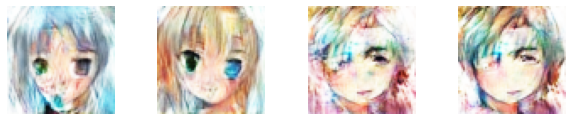

6600 [D loss: 0.097582, acc.: 95.70%] [G loss: 4.336734]
6700 [D loss: 0.098222, acc.: 97.66%] [G loss: 4.545193]
6800 [D loss: 0.062665, acc.: 98.05%] [G loss: 5.049781]
6900 [D loss: 0.043285, acc.: 99.22%] [G loss: 4.743011]
7000 [D loss: 0.139620, acc.: 94.53%] [G loss: 5.606802]


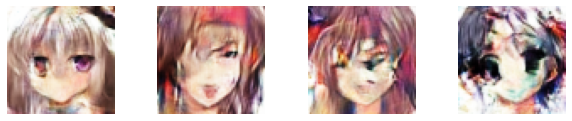

7100 [D loss: 0.017715, acc.: 100.00%] [G loss: 4.686208]
7200 [D loss: 0.056223, acc.: 99.22%] [G loss: 5.610648]
7300 [D loss: 1.261454, acc.: 75.00%] [G loss: 2.811322]
7400 [D loss: 0.149302, acc.: 95.31%] [G loss: 4.576947]
7500 [D loss: 0.054861, acc.: 98.44%] [G loss: 4.272511]


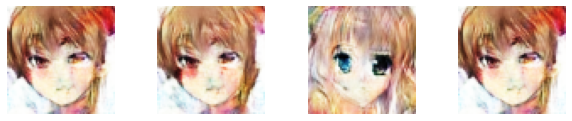

7600 [D loss: 0.111530, acc.: 96.88%] [G loss: 5.430285]
7700 [D loss: 0.056805, acc.: 98.05%] [G loss: 5.372417]
7800 [D loss: 0.898811, acc.: 70.70%] [G loss: 7.505275]
7900 [D loss: 0.046783, acc.: 98.44%] [G loss: 5.155417]
8000 [D loss: 0.078565, acc.: 97.27%] [G loss: 5.252959]


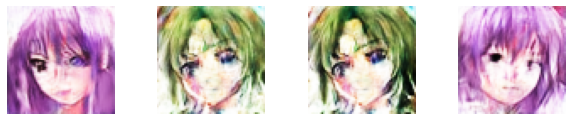

8100 [D loss: 0.025154, acc.: 99.61%] [G loss: 4.814104]
8200 [D loss: 0.040837, acc.: 99.22%] [G loss: 4.600361]
8300 [D loss: 0.106558, acc.: 97.27%] [G loss: 3.563672]
8400 [D loss: 0.176355, acc.: 94.92%] [G loss: 5.145923]
8500 [D loss: 0.042245, acc.: 99.22%] [G loss: 3.892687]


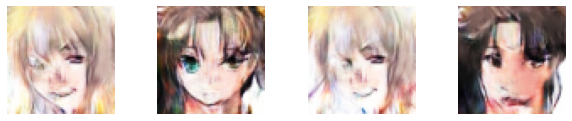

8600 [D loss: 0.110499, acc.: 96.09%] [G loss: 4.122021]
8700 [D loss: 0.081582, acc.: 98.05%] [G loss: 4.409911]
8800 [D loss: 0.662060, acc.: 75.00%] [G loss: 10.907679]
8900 [D loss: 0.137266, acc.: 96.48%] [G loss: 4.382471]
9000 [D loss: 0.142389, acc.: 95.70%] [G loss: 4.173635]


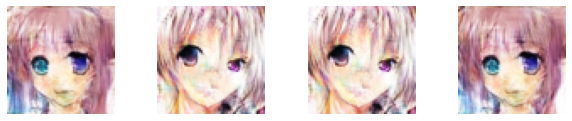

9100 [D loss: 0.049083, acc.: 98.44%] [G loss: 4.126584]
9200 [D loss: 0.074674, acc.: 98.05%] [G loss: 4.066189]
9300 [D loss: 0.070388, acc.: 97.66%] [G loss: 4.957605]
9400 [D loss: 0.040551, acc.: 100.00%] [G loss: 4.241319]
9500 [D loss: 0.024614, acc.: 99.61%] [G loss: 4.784786]


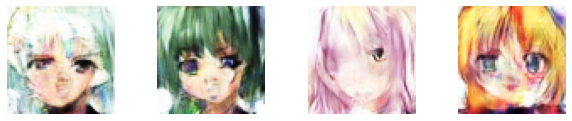

9600 [D loss: 0.083342, acc.: 98.83%] [G loss: 3.999189]
9700 [D loss: 0.748681, acc.: 71.09%] [G loss: 5.764571]
9800 [D loss: 0.170496, acc.: 96.48%] [G loss: 2.904111]
9900 [D loss: 0.165915, acc.: 94.53%] [G loss: 3.969382]
10000 [D loss: 0.056601, acc.: 98.83%] [G loss: 4.614398]


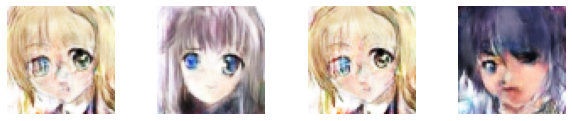

10100 [D loss: 0.027702, acc.: 98.83%] [G loss: 5.148424]
10200 [D loss: 0.160424, acc.: 94.92%] [G loss: 3.398750]
10300 [D loss: 0.081490, acc.: 97.66%] [G loss: 4.392717]
10400 [D loss: 0.532707, acc.: 70.70%] [G loss: 3.685106]
10500 [D loss: 0.224419, acc.: 93.36%] [G loss: 3.061707]


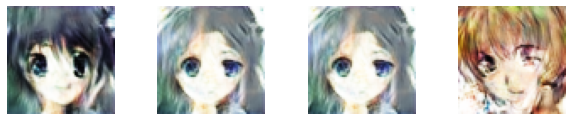

10600 [D loss: 0.054387, acc.: 98.05%] [G loss: 6.845257]
10700 [D loss: 0.055638, acc.: 98.05%] [G loss: 4.266853]
10800 [D loss: 0.036635, acc.: 98.83%] [G loss: 6.203026]
10900 [D loss: 0.133705, acc.: 96.48%] [G loss: 6.308214]
11000 [D loss: 0.017854, acc.: 99.22%] [G loss: 5.792884]


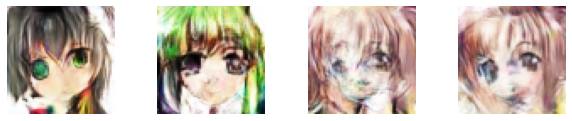

11100 [D loss: 0.024696, acc.: 99.61%] [G loss: 4.809032]
11200 [D loss: 0.086209, acc.: 97.66%] [G loss: 3.387874]
11300 [D loss: 0.063441, acc.: 98.44%] [G loss: 5.721804]
11400 [D loss: 0.038516, acc.: 99.22%] [G loss: 5.027699]
11500 [D loss: 0.038807, acc.: 99.61%] [G loss: 4.063328]


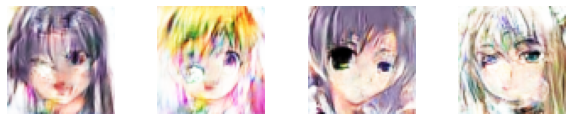

11600 [D loss: 0.053519, acc.: 98.44%] [G loss: 5.140110]
11700 [D loss: 0.079403, acc.: 97.66%] [G loss: 8.614339]
11800 [D loss: 0.032252, acc.: 99.22%] [G loss: 6.015444]
11900 [D loss: 0.075924, acc.: 97.27%] [G loss: 6.477654]
12000 [D loss: 0.246822, acc.: 93.36%] [G loss: 4.306720]


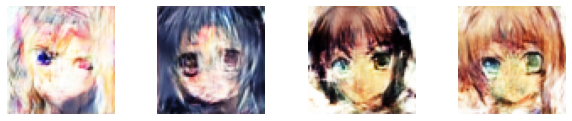

12100 [D loss: 0.565629, acc.: 71.48%] [G loss: 2.985766]
12200 [D loss: 0.043420, acc.: 98.44%] [G loss: 4.990017]
12300 [D loss: 0.048388, acc.: 98.44%] [G loss: 5.563227]
12400 [D loss: 0.147840, acc.: 93.75%] [G loss: 4.145824]
12500 [D loss: 0.211034, acc.: 92.97%] [G loss: 4.699953]


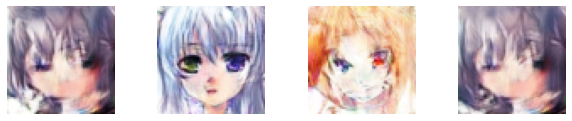

12600 [D loss: 0.135701, acc.: 96.09%] [G loss: 6.003426]
12700 [D loss: 0.019107, acc.: 99.22%] [G loss: 5.029596]
12800 [D loss: 0.019713, acc.: 99.61%] [G loss: 5.844581]
12900 [D loss: 0.058052, acc.: 98.83%] [G loss: 4.858279]
13000 [D loss: 0.064099, acc.: 98.44%] [G loss: 6.363216]


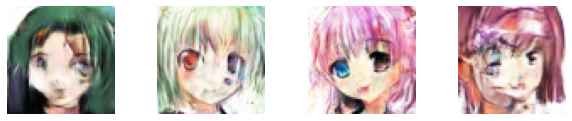

13100 [D loss: 0.037938, acc.: 99.61%] [G loss: 5.292680]
13200 [D loss: 0.034031, acc.: 98.83%] [G loss: 6.857099]
13300 [D loss: 0.166558, acc.: 95.31%] [G loss: 7.490834]
13400 [D loss: 0.032324, acc.: 98.44%] [G loss: 4.476799]
13500 [D loss: 0.066668, acc.: 98.44%] [G loss: 4.236990]


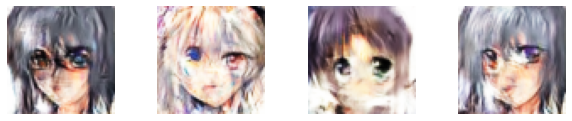

13600 [D loss: 0.149699, acc.: 94.92%] [G loss: 3.476376]
13700 [D loss: 0.059610, acc.: 98.44%] [G loss: 6.300936]
13800 [D loss: 0.055770, acc.: 97.66%] [G loss: 4.618797]
13900 [D loss: 0.514539, acc.: 89.84%] [G loss: 11.762407]
14000 [D loss: 0.318618, acc.: 83.20%] [G loss: 4.260567]


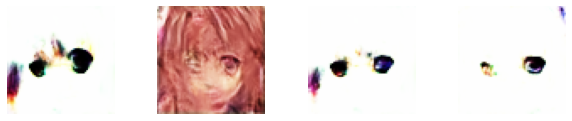

14100 [D loss: 0.191096, acc.: 95.31%] [G loss: 3.578188]
14200 [D loss: 0.113373, acc.: 97.27%] [G loss: 4.053880]
14300 [D loss: 0.250523, acc.: 91.02%] [G loss: 3.288780]
14400 [D loss: 0.153722, acc.: 96.09%] [G loss: 4.046150]
14500 [D loss: 0.071386, acc.: 98.44%] [G loss: 3.824745]


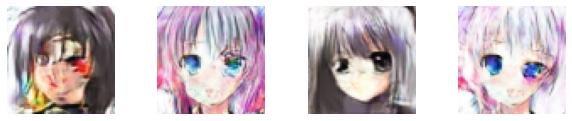

14600 [D loss: 0.207523, acc.: 90.23%] [G loss: 4.632793]
14700 [D loss: 0.131749, acc.: 94.53%] [G loss: 4.385020]
14800 [D loss: 0.108674, acc.: 95.70%] [G loss: 5.023368]
14900 [D loss: 0.043169, acc.: 99.22%] [G loss: 5.074619]
15000 [D loss: 0.060665, acc.: 97.66%] [G loss: 4.324836]


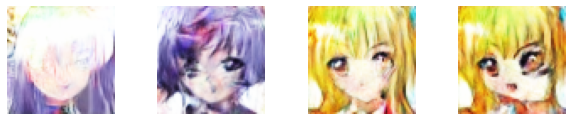

15100 [D loss: 0.051634, acc.: 98.44%] [G loss: 4.208694]
15200 [D loss: 0.022742, acc.: 99.22%] [G loss: 4.596823]
15300 [D loss: 0.067867, acc.: 98.44%] [G loss: 4.245670]
15400 [D loss: 0.120635, acc.: 95.70%] [G loss: 4.884212]
15500 [D loss: 0.026924, acc.: 99.61%] [G loss: 5.545567]


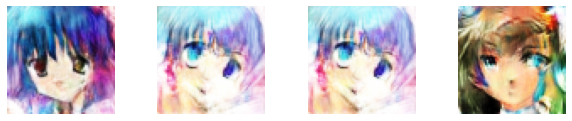

15600 [D loss: 0.049304, acc.: 98.83%] [G loss: 4.770794]
15700 [D loss: 0.207047, acc.: 89.06%] [G loss: 9.439898]
15800 [D loss: 0.030886, acc.: 99.22%] [G loss: 5.554846]
15900 [D loss: 0.070641, acc.: 98.83%] [G loss: 5.021105]
16000 [D loss: 0.043402, acc.: 99.22%] [G loss: 4.947891]


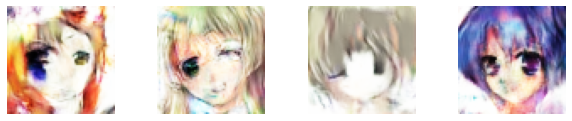

16100 [D loss: 0.061164, acc.: 99.61%] [G loss: 7.775767]
16200 [D loss: 0.084257, acc.: 97.27%] [G loss: 5.956637]
16300 [D loss: 0.361238, acc.: 82.03%] [G loss: 6.883895]
16400 [D loss: 0.090315, acc.: 98.05%] [G loss: 5.192210]
16500 [D loss: 0.065495, acc.: 98.83%] [G loss: 5.113324]


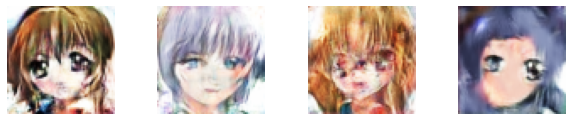

16600 [D loss: 0.054934, acc.: 98.44%] [G loss: 4.235393]
16700 [D loss: 0.013942, acc.: 99.61%] [G loss: 4.530310]
16800 [D loss: 0.054686, acc.: 98.44%] [G loss: 5.724187]
16900 [D loss: 0.029701, acc.: 99.22%] [G loss: 4.760178]
17000 [D loss: 0.032604, acc.: 98.83%] [G loss: 5.930369]


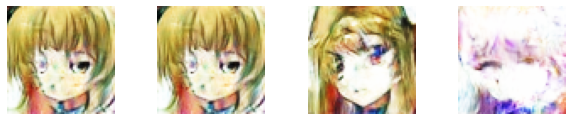

17100 [D loss: 0.029680, acc.: 99.22%] [G loss: 5.072220]
17200 [D loss: 0.017539, acc.: 99.22%] [G loss: 7.378328]
17300 [D loss: 0.018260, acc.: 99.61%] [G loss: 5.149459]
17400 [D loss: 0.158793, acc.: 92.58%] [G loss: 8.807873]
17500 [D loss: 0.036042, acc.: 98.83%] [G loss: 4.505681]


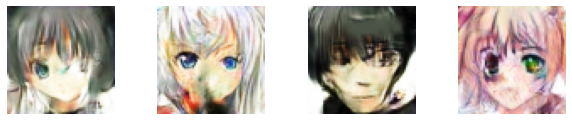

17600 [D loss: 0.081168, acc.: 98.05%] [G loss: 6.088346]
17700 [D loss: 0.022389, acc.: 99.61%] [G loss: 6.193376]
17800 [D loss: 0.009602, acc.: 99.61%] [G loss: 5.873016]
17900 [D loss: 0.039961, acc.: 98.05%] [G loss: 6.411804]
18000 [D loss: 0.044228, acc.: 98.83%] [G loss: 7.020361]


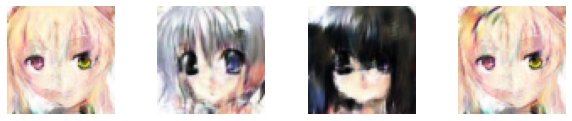

18100 [D loss: 0.062596, acc.: 98.05%] [G loss: 7.105730]
18200 [D loss: 0.273371, acc.: 85.55%] [G loss: 11.100769]
18300 [D loss: 0.222002, acc.: 86.72%] [G loss: 10.087985]
18400 [D loss: 0.019087, acc.: 99.61%] [G loss: 5.271711]
18500 [D loss: 0.067707, acc.: 99.22%] [G loss: 6.675816]


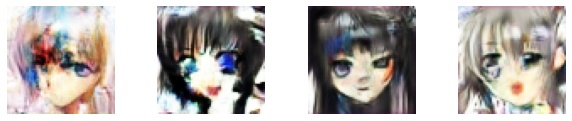

18600 [D loss: 0.090974, acc.: 97.27%] [G loss: 5.371932]
18700 [D loss: 0.023558, acc.: 99.22%] [G loss: 5.813773]
18800 [D loss: 0.109685, acc.: 96.88%] [G loss: 5.508715]
18900 [D loss: 0.034479, acc.: 98.44%] [G loss: 7.059901]
19000 [D loss: 0.038353, acc.: 99.61%] [G loss: 6.824382]


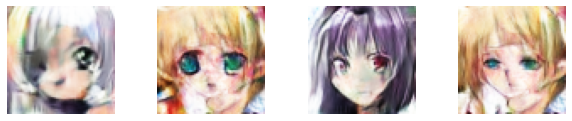

19100 [D loss: 0.056693, acc.: 99.61%] [G loss: 7.877278]
19200 [D loss: 0.010619, acc.: 99.22%] [G loss: 6.368458]
19300 [D loss: 0.024044, acc.: 99.22%] [G loss: 3.421329]
19400 [D loss: 0.013685, acc.: 99.61%] [G loss: 6.104145]
19500 [D loss: 0.045468, acc.: 98.44%] [G loss: 6.484938]


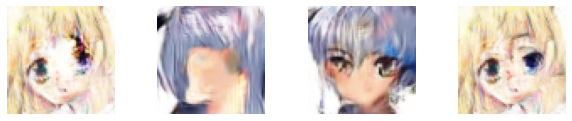

19600 [D loss: 0.009542, acc.: 100.00%] [G loss: 4.748972]
19700 [D loss: 0.111265, acc.: 95.31%] [G loss: 9.391568]
19800 [D loss: 0.040070, acc.: 98.44%] [G loss: 6.490862]
19900 [D loss: 0.017137, acc.: 100.00%] [G loss: 6.701805]
20000 [D loss: 0.080110, acc.: 96.88%] [G loss: 8.353437]


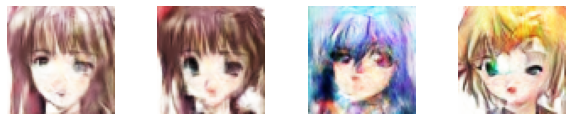

20100 [D loss: 0.014482, acc.: 99.61%] [G loss: 5.857419]
20200 [D loss: 0.062023, acc.: 99.22%] [G loss: 10.219140]
20300 [D loss: 0.014212, acc.: 99.61%] [G loss: 5.958190]
20400 [D loss: 0.015027, acc.: 99.61%] [G loss: 5.757702]
20500 [D loss: 0.023304, acc.: 99.61%] [G loss: 4.971305]


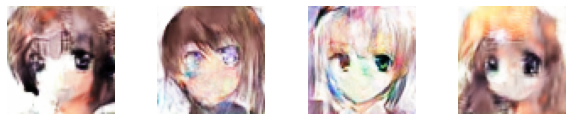

20600 [D loss: 0.016470, acc.: 99.61%] [G loss: 6.510777]
20700 [D loss: 0.031414, acc.: 98.83%] [G loss: 8.592756]
20800 [D loss: 0.024697, acc.: 98.83%] [G loss: 6.311766]
20900 [D loss: 0.047948, acc.: 98.83%] [G loss: 9.807631]
21000 [D loss: 0.009559, acc.: 99.61%] [G loss: 7.414215]


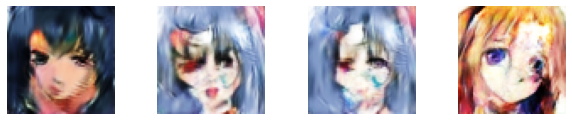

21100 [D loss: 0.142027, acc.: 97.66%] [G loss: 6.993679]
21200 [D loss: 0.054101, acc.: 97.27%] [G loss: 6.644108]
21300 [D loss: 0.033074, acc.: 98.83%] [G loss: 4.526934]
21400 [D loss: 0.010257, acc.: 100.00%] [G loss: 6.018173]
21500 [D loss: 0.025867, acc.: 98.83%] [G loss: 6.940487]


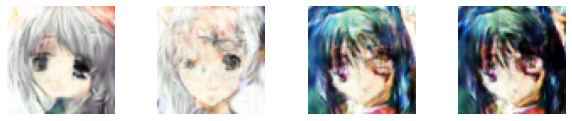

21600 [D loss: 0.011430, acc.: 99.22%] [G loss: 6.981647]
21700 [D loss: 0.038454, acc.: 98.44%] [G loss: 7.068466]
21800 [D loss: 0.063236, acc.: 97.66%] [G loss: 12.465763]
21900 [D loss: 0.049194, acc.: 99.22%] [G loss: 7.514387]
22000 [D loss: 0.071480, acc.: 98.83%] [G loss: 4.833334]


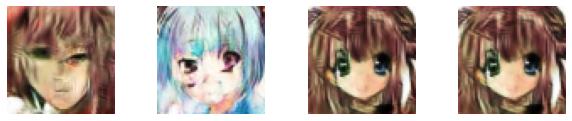

22100 [D loss: 0.126692, acc.: 95.31%] [G loss: 7.391623]
22200 [D loss: 0.018764, acc.: 100.00%] [G loss: 5.201597]
22300 [D loss: 0.057797, acc.: 98.05%] [G loss: 4.177731]
22400 [D loss: 0.004930, acc.: 100.00%] [G loss: 7.685115]
22500 [D loss: 0.028892, acc.: 98.44%] [G loss: 8.622863]


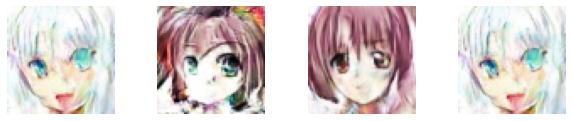

22600 [D loss: 0.019395, acc.: 99.61%] [G loss: 7.204302]
22700 [D loss: 0.009559, acc.: 100.00%] [G loss: 7.628121]
22800 [D loss: 1.641151, acc.: 77.73%] [G loss: 3.488126]
22900 [D loss: 0.040373, acc.: 98.83%] [G loss: 6.146179]
23000 [D loss: 0.095388, acc.: 98.05%] [G loss: 4.624838]


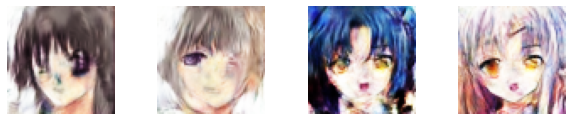

23100 [D loss: 0.022471, acc.: 99.22%] [G loss: 5.177381]
23200 [D loss: 0.045959, acc.: 98.44%] [G loss: 5.022259]
23300 [D loss: 0.070753, acc.: 98.44%] [G loss: 5.372361]
23400 [D loss: 0.041427, acc.: 99.22%] [G loss: 6.850190]
23500 [D loss: 1.110968, acc.: 60.55%] [G loss: 15.255579]


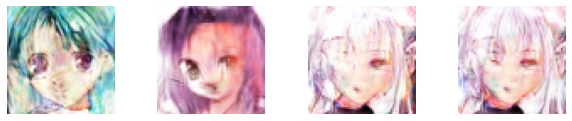

23600 [D loss: 0.118975, acc.: 94.92%] [G loss: 9.498766]
23700 [D loss: 0.014003, acc.: 100.00%] [G loss: 5.513699]
23800 [D loss: 0.019147, acc.: 100.00%] [G loss: 7.840358]
23900 [D loss: 0.019633, acc.: 99.61%] [G loss: 6.870653]
24000 [D loss: 0.378976, acc.: 82.03%] [G loss: 16.611595]


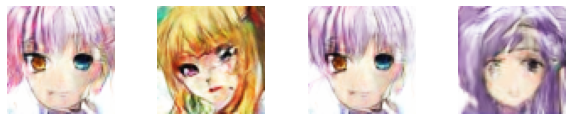

24100 [D loss: 0.012909, acc.: 100.00%] [G loss: 5.574639]
24200 [D loss: 0.030127, acc.: 99.22%] [G loss: 5.291619]
24300 [D loss: 0.019397, acc.: 99.61%] [G loss: 5.845049]
24400 [D loss: 0.049941, acc.: 98.05%] [G loss: 7.458062]
24500 [D loss: 0.011239, acc.: 99.61%] [G loss: 4.936636]


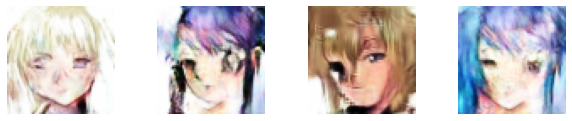

24600 [D loss: 0.048388, acc.: 99.22%] [G loss: 5.180156]
24700 [D loss: 0.078713, acc.: 98.44%] [G loss: 8.481358]
24800 [D loss: 0.014416, acc.: 99.22%] [G loss: 5.869195]
24900 [D loss: 0.052469, acc.: 98.44%] [G loss: 6.579806]
25000 [D loss: 0.002527, acc.: 100.00%] [G loss: 7.348883]


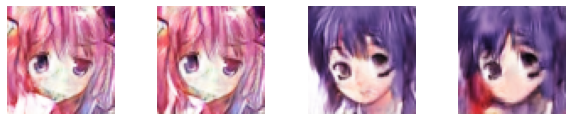

25100 [D loss: 0.004578, acc.: 100.00%] [G loss: 7.704969]
25200 [D loss: 0.028544, acc.: 99.22%] [G loss: 5.206980]
25300 [D loss: 0.072324, acc.: 98.44%] [G loss: 7.219982]
25400 [D loss: 0.017152, acc.: 99.61%] [G loss: 6.789247]
25500 [D loss: 0.033619, acc.: 98.83%] [G loss: 4.359829]


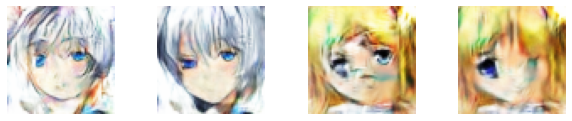

25600 [D loss: 0.023175, acc.: 99.22%] [G loss: 4.632064]
25700 [D loss: 0.051050, acc.: 98.83%] [G loss: 4.859989]
25800 [D loss: 0.024292, acc.: 99.22%] [G loss: 5.747139]
25900 [D loss: 0.004546, acc.: 100.00%] [G loss: 5.347620]
26000 [D loss: 0.029428, acc.: 98.83%] [G loss: 7.568435]


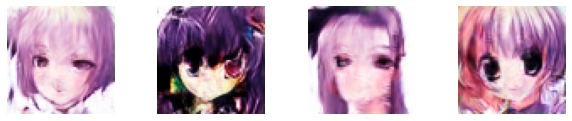

26100 [D loss: 0.019507, acc.: 99.61%] [G loss: 6.355444]
26200 [D loss: 0.007168, acc.: 100.00%] [G loss: 5.041506]
26300 [D loss: 0.078291, acc.: 96.09%] [G loss: 11.042311]
26400 [D loss: 0.001173, acc.: 100.00%] [G loss: 7.001766]
26500 [D loss: 0.010036, acc.: 100.00%] [G loss: 6.653640]


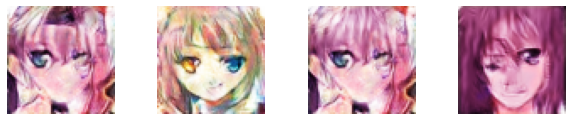

26600 [D loss: 0.122756, acc.: 96.88%] [G loss: 8.518341]
26700 [D loss: 0.020763, acc.: 99.61%] [G loss: 4.482662]
26800 [D loss: 0.047683, acc.: 98.44%] [G loss: 6.718153]
26900 [D loss: 0.016668, acc.: 99.61%] [G loss: 4.686764]
27000 [D loss: 0.009125, acc.: 100.00%] [G loss: 5.309370]


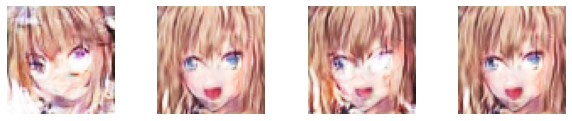

27100 [D loss: 0.081102, acc.: 97.27%] [G loss: 5.414263]
27200 [D loss: 0.030937, acc.: 99.22%] [G loss: 5.487609]
27300 [D loss: 0.022280, acc.: 99.61%] [G loss: 8.243034]
27400 [D loss: 0.022629, acc.: 99.61%] [G loss: 6.593486]
27500 [D loss: 0.024687, acc.: 99.61%] [G loss: 8.565138]


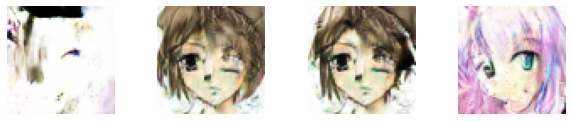

27600 [D loss: 0.028093, acc.: 99.22%] [G loss: 4.386427]
27700 [D loss: 0.018160, acc.: 99.61%] [G loss: 8.505318]
27800 [D loss: 0.027757, acc.: 99.61%] [G loss: 8.327097]
27900 [D loss: 0.029627, acc.: 100.00%] [G loss: 6.795088]
28000 [D loss: 0.079338, acc.: 97.66%] [G loss: 4.718895]


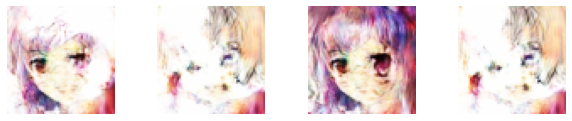

28100 [D loss: 0.042510, acc.: 99.22%] [G loss: 6.700180]
28200 [D loss: 0.037235, acc.: 99.61%] [G loss: 5.503819]
28300 [D loss: 0.065628, acc.: 97.66%] [G loss: 6.961627]
28400 [D loss: 0.014075, acc.: 99.22%] [G loss: 7.335788]
28500 [D loss: 0.042721, acc.: 98.44%] [G loss: 5.497077]


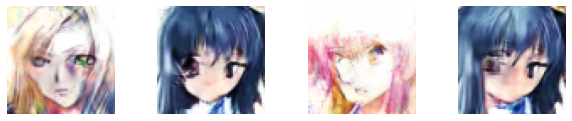

28600 [D loss: 0.016696, acc.: 99.22%] [G loss: 6.063472]
28700 [D loss: 0.015113, acc.: 99.61%] [G loss: 6.940916]
28800 [D loss: 0.032164, acc.: 99.22%] [G loss: 6.790555]
28900 [D loss: 0.018475, acc.: 99.61%] [G loss: 6.574936]
29000 [D loss: 0.024712, acc.: 99.22%] [G loss: 4.967808]


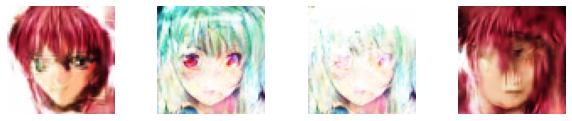

29100 [D loss: 0.020570, acc.: 100.00%] [G loss: 6.632350]
29200 [D loss: 0.016058, acc.: 99.61%] [G loss: 5.452051]
29300 [D loss: 0.003020, acc.: 100.00%] [G loss: 12.462584]
29400 [D loss: 0.042790, acc.: 100.00%] [G loss: 9.360470]
29500 [D loss: 0.089516, acc.: 98.05%] [G loss: 5.805861]


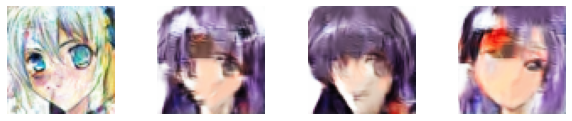

29600 [D loss: 0.008358, acc.: 100.00%] [G loss: 5.721577]
29700 [D loss: 0.010671, acc.: 99.61%] [G loss: 4.805164]
29800 [D loss: 0.005163, acc.: 100.00%] [G loss: 3.135121]
29900 [D loss: 0.004757, acc.: 100.00%] [G loss: 5.202805]
30000 [D loss: 0.118126, acc.: 95.70%] [G loss: 4.384752]


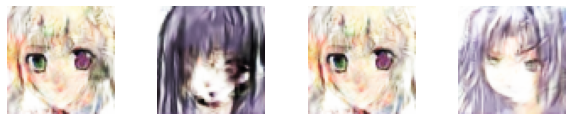

In [0]:
train(generator,discriminator,combined,imgs, latent_dim,start_epoch = 0,epochs= 30001,batch_size=128, sample_interval=500, )

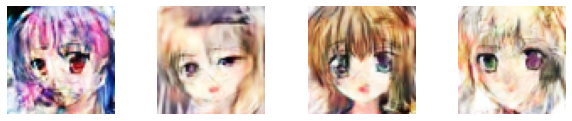

In [0]:
r, c = 2, 2
noise = np.random.normal(0, 1, (r * c, latent_dim))
gen_imgs = generator.predict(noise)
# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(r * c):
      img = gen_imgs[i].squeeze()
      sub = fig.add_subplot(2, r * c, i+1)
      sub.axis('off')        
      sub.imshow(img)
plt.show()
